In [308]:
import pandas as pd
import numpy as np
import ast
# COL of interest: review_scores_rating
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.impute import KNNImputer
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from itertools import product
from sklearn.metrics import mean_squared_error
from sklearn.svm import SVR

## Introduction
We will be predicting the average rating for San Francisco AirBNB listings. The rating is a continuous value from 1 to 5 stars. We are given various features about the listing such as the price, amenities, host response rate, room type, number of beds, and where the host lives.

In [109]:
df = pd.read_csv('sf1.csv')
df.drop(columns=['id','scrape_id', 'listing_url', 'source', 'description', 'calendar_updated',
                 'bedrooms', 'bathrooms', 'neighbourhood_group_cleansed', 'picture_url',
                 'host_id', 'host_url', 'host_thumbnail_url', 'host_picture_url', 'host_name',
                 'neighbourhood', 'last_scraped', 'property_type', 'calendar_last_scraped', 'review_scores_accuracy',
                 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location',
                 'review_scores_value'], inplace=True)

In [469]:
df

,name,neighborhood_overview,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_neighbourhood,...,days_as_host,num_host_verifications,days_since_first_review,days_since_last_review,has_license,num_amenities,has_host_about,price group,amenities_group,binned_rating
0,Home in San Francisco · ★4.91 · 4 bedrooms · 4...,The home is walking distance from lots of loca...,2011-05-31,"San Francisco, CA","We are Julie and Brad, a San Francisco based v...",within an hour,100.000000,100.000000,False,The Castro,...,4677.0,3.0,4580.0,215.0,True,60,True,"(275, 50000]","(49, 166]",5
1,Home in San Francisco · ★4.91 · 2 bedrooms · 2...,Excelsior is south of the Mission district and...,2012-05-08,"San Francisco, CA","I'm from San Francisco, but am of Cuban descen...",within a few hours,100.000000,100.000000,True,Excelsior,...,4334.0,2.0,2430.0,127.0,True,68,True,"(0, 86]","(49, 166]",5
2,Rental unit in San Francisco · ★4.53 · 3 bedro...,A gourmet hidden gem with spectacular views of...,2012-05-19,"San Francisco, CA",We are a French family living in San Francisco...,within a few hours,100.000000,60.000000,False,Potrero Hill,...,4323.0,2.0,4224.0,246.0,True,58,True,"(174, 275]","(49, 166]",5
3,Rental unit in San Francisco · ★4.78 · 1 bedro...,The Mission Dolores area is consider one of th...,2012-02-01,"San Francisco, CA",Software Designer - World Traveling Surfer,within an hour,100.000000,86.000000,True,Mission District,...,4431.0,2.0,4277.0,137.0,False,27,True,"(123, 174]","(21, 30]",5
4,Condo in San Francisco · 2 bedrooms · 2 beds ·...,the Mission is a simmering cauldron of culture...,2012-03-13,"San Francisco, CA",I am laid back girl that loves exploring new p...,Unknown,97.443814,90.687291,False,Mission District,...,4390.0,2.0,2805.0,2721.0,False,17,True,"(0, 86]","(0, 21]",5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7948,Rental unit in San Francisco · ★New · 2 bedroo...,NaN,2011-12-23,"San Francisco, CA",NaN,within an hour,100.000000,50.000000,False,Rincon Hill,...,4471.0,1.0,115.0,115.0,True,58,False,"(275, 50000]","(49, 166]",5
7953,Home in San Francisco · ★New · 3 bedrooms · 4 ...,NaN,2022-11-22,NaN,NaN,within an hour,100.000000,100.000000,False,Ingleside,...,484.0,2.0,119.0,119.0,True,34,False,"(86, 123]","(30, 39]",5
7967,Rental unit in San Francisco · ★New · 3 bedroo...,NaN,2014-01-15,"San Francisco, CA",NaN,within an hour,100.000000,100.000000,False,Mission District,...,3717.0,3.0,116.0,116.0,True,12,False,"(275, 50000]","(0, 21]",5
7984,Guesthouse in San Francisco · ★New · 1 bedroom...,NaN,2023-11-17,NaN,NaN,within an hour,100.000000,100.000000,False,Excelsior,...,124.0,1.0,116.0,116.0,True,35,False,"(86, 123]","(30, 39]",5


In [110]:
df.dropna(subset=['review_scores_rating'], inplace=True) # drop records with N/A for the response

In [111]:
df['has_neighborhood_overview'] = [True if pd.isna(overview) == False else False for overview in df['neighborhood_overview']]
df['host_in_SF'] = [True if (pd.isna(location) == False) and ('San Francisco' in location) else False for location in df['host_location']]
for idx in df.index:
    loc = df.loc[idx, 'host_location']
    if pd.isna(loc):
        df.loc[idx, 'host_in_SF'] = 'Unknown'

df['days_as_host'] = [(pd.Timestamp.now() - pd.to_datetime(host_since)).days if pd.isna(host_since) == False else
                      None for host_since in df['host_since']]
df['host_is_superhost'] = [True if status == 't' else False for status in df['host_is_superhost']]
df['host_verifications'] = [ast.literal_eval(ver) if pd.isna(ver) == False else ver for ver in df['host_verifications']]

for idx in df.index:
    if idx == 540:
        df.loc[idx, 'num_host_verifications'] = None
        continue
    host_verifications = df.loc[idx, 'host_verifications']
    df.loc[idx, 'num_host_verifications'] = len(host_verifications)

df['host_has_profile_pic'] = [True if status == 't' else False for status in df['host_has_profile_pic']]
df['host_identity_verified'] = [True if status == 't' else False for status in df['host_identity_verified']]
df['has_availability'] = [True if status == 't' else False for status in df['has_availability']]
df['days_since_first_review'] = [(pd.Timestamp.now() - pd.to_datetime(date)).days if pd.isna(date) == False else None for date in df['first_review']]
df['days_since_last_review'] = [(pd.Timestamp.now() - pd.to_datetime(date)).days if pd.isna(date) == False else None for date in df['last_review']]
df['has_license'] = [True if pd.isna(lic) == False else False for lic in df['license']]
df['instant_bookable'] = [True if status == 't' else False for status in df['instant_bookable']]
df['amenities'] = [ast.literal_eval(amenities) for amenities in df['amenities']]
df['num_amenities'] = [len(amenities) for amenities in df['amenities']]
df['has_host_about'] = [True if pd.isna(about) == False else False for about in df['host_about']]

for idx in df.index:
    rate1  = df.loc[idx, 'host_response_rate']
    if pd.isna(rate1):
        int_rate1 = rate1
        continue
    if (pd.isna(rate1) == False) and (len(rate1) == 4):
        int_rate1 = int(rate1[:3])
    if len(rate1) == 3:
        int_rate1 = int(rate1[:2])
    df.loc[idx, 'host_response_rate'] = int_rate1
for idx in df.index:
    rate2 = df.loc[idx, 'host_acceptance_rate']
    if pd.isna(rate2):
        int_rate2 = rate2
        continue
    if (len(rate2) == 4) and (pd.isna(rate2) == False):
        int_rate2 = int(rate2[:3])
    if len(rate2) == 3:
        int_rate2 = int(rate2[:2])
    df.loc[idx, 'host_acceptance_rate'] = int_rate2

df['price'] = [price.replace(',', '') for price in df['price']]
df['price'] = [float(price[1:]) for price in df['price']]

In [112]:
df['host_response_rate'] = df['host_response_rate'].astype(float)
df['host_acceptance_rate'] = df['host_acceptance_rate'].astype(float)

Impute missing numerical values using KNNImputer()

In [113]:
knn_imputer1 = KNNImputer(n_neighbors=3)
df['beds'] = knn_imputer1.fit_transform(df['beds'].to_numpy().reshape(-1,1))

df['host_response_time'].fillna('Unknown', inplace=True)

knn_imputer2 = KNNImputer(n_neighbors=3)
df['host_response_rate'] = knn_imputer2.fit_transform(df['host_response_rate'].to_numpy().reshape(-1,1))

knn_imputer3 = KNNImputer(n_neighbors=3)
df['host_acceptance_rate'] = knn_imputer3.fit_transform(df['host_acceptance_rate'].to_numpy().reshape(-1,1))

knn_imputer4 = KNNImputer(n_neighbors=3)
df['num_host_verifications'] = knn_imputer4.fit_transform(df['num_host_verifications'].to_numpy().reshape(-1,1))

knn_imputer5 = KNNImputer(n_neighbors=3)
df['days_since_first_review'] = knn_imputer5.fit_transform(df['days_since_first_review'].to_numpy().reshape(-1,1))

knn_imputer6 = KNNImputer(n_neighbors=3)
df['days_since_last_review'] = knn_imputer6.fit_transform(df['days_since_last_review'].to_numpy().reshape(-1,1))

In [114]:
knn_imputer7 = KNNImputer(n_neighbors=3)
df['reviews_per_month'] = knn_imputer7.fit_transform(df['reviews_per_month'].to_numpy().reshape(-1,1))

knn_imputer8 = KNNImputer(n_neighbors=3)
df['days_as_host'] = knn_imputer8.fit_transform(df['days_as_host'].to_numpy().reshape(-1,1))


# EDA SECTION

distribution of reviews

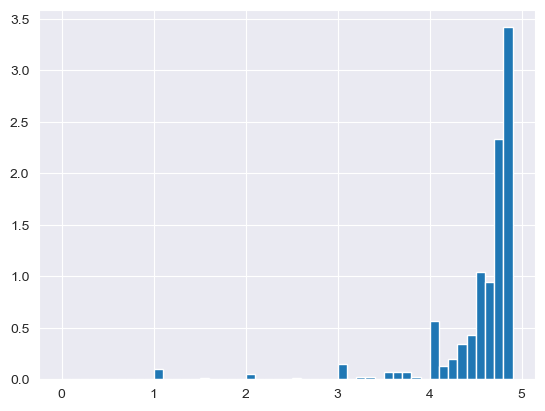

In [115]:
import seaborn as sns
from scipy.stats import gaussian_kde
plt.hist(df['review_scores_rating'], bins=np.arange(0, 5, 0.1), density=True)
# plt.hist(kde)
plt.show()

Does price impact the rating?

In [116]:
bins = [0, 86, 123, 174, 275, 50000 ] # 0.2, 0.4, 0.6, 0.8, 1 quantiles
df['price group'] = pd.cut(df['price'], bins=bins)
df.groupby('price group')[['review_scores_rating']].median() # higher price = higher rating

,review_scores_rating
price group,
"(0, 86]",4.80
"(86, 123]",4.87
"(123, 174]",4.90
"(174, 275]",4.94
"(275, 50000]",4.96


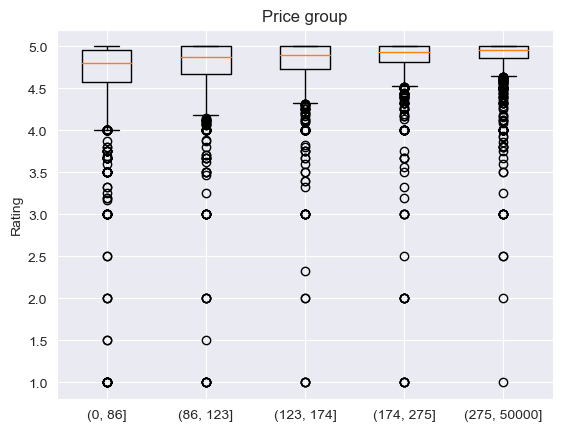

In [117]:
data = []
labs = []
for status in np.sort(df['price group'].unique()):
    vals = df.loc[df['price group'] == status, 'review_scores_rating']
    data.append(vals)
    labs.append(status)
# make the kde histograms so we can see the curves shifting
plt.boxplot(data)
plt.xticks([1,2, 3, 4, 5], labs)
plt.ylabel('Rating')
plt.title('Price group')
plt.show()
# the higher the price group, the higher the rating and the lower the IQR. Perhaps price will be a useful predictor of rating?

Do super hosts have higher median ratings?

In [118]:
df.groupby('host_is_superhost')[['review_scores_rating']].median() # super hosts have higher median reviews

,review_scores_rating
host_is_superhost,
False,4.83
True,4.93


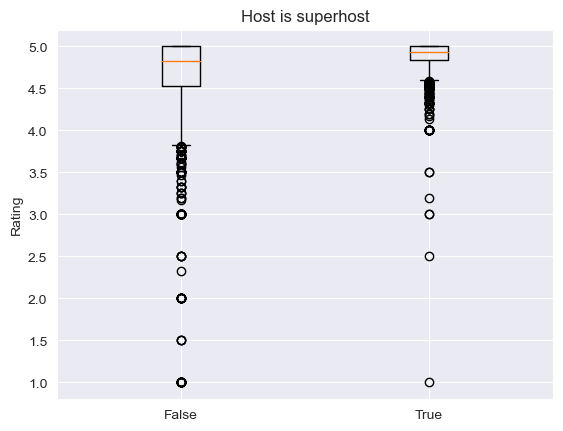

In [119]:
data = []
labs = []
for status in df['host_is_superhost'].unique():
    vals = df.loc[df['host_is_superhost'] == status, 'review_scores_rating']
    data.append(vals)
    labs.append(status)

plt.boxplot(data)
plt.xticks([1,2], labs)
plt.ylabel('Rating')
plt.title('Host is superhost')
plt.show()

Does the host being in San Francisco impact the reviews?

In [120]:
df.groupby('host_in_SF')[['review_scores_rating']].median() # not being in SF has higher median reviews

,review_scores_rating
host_in_SF,
False,4.94
True,4.91
Unknown,4.81


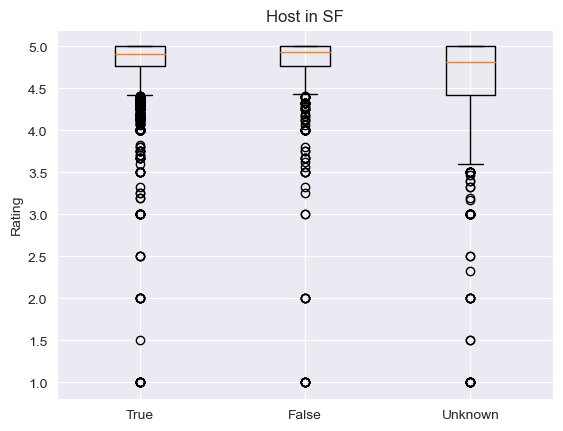

In [121]:
data = []
labs = []
for status in df['host_in_SF'].unique():
    vals = df.loc[df['host_in_SF'] == status, 'review_scores_rating']
    data.append(vals)
    labs.append(status)

plt.boxplot(data)
plt.xticks([1,2, 3], labs)
plt.ylabel('Rating')
plt.title('Host in SF')
plt.show()

num host verifications

In [126]:
df.groupby('num_host_verifications')[['review_scores_rating']].median() # more host verifications = higher rating

,review_scores_rating
num_host_verifications,
1.000000,4.87
2.000000,4.90
2.097182,4.86
3.000000,4.91


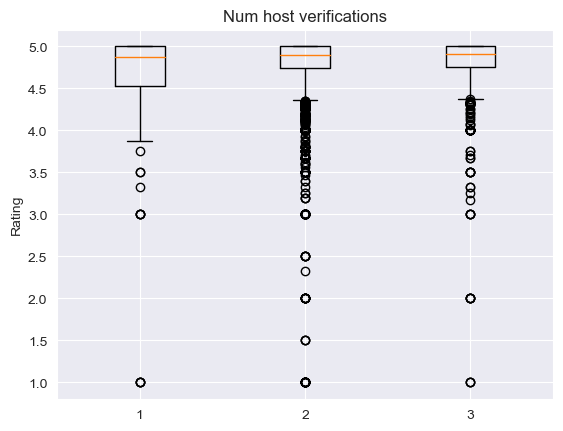

In [124]:
data = []
labs = []
for status in [1, 2, 3]:
    vals = df.loc[df['num_host_verifications'] == status, 'review_scores_rating']
    data.append(vals)
    labs.append(status)

plt.boxplot(data)
plt.xticks([1,2,3], labs)
plt.ylabel('Rating')
plt.title('Num host verifications')
plt.show()

Does the room type impact the rating?

In [127]:
df.groupby('room_type')[['review_scores_rating']].median() # hotel room has the lowest reviews

,review_scores_rating
room_type,
Entire home/apt,4.93
Hotel room,4.46
Private room,4.86
Shared room,4.73


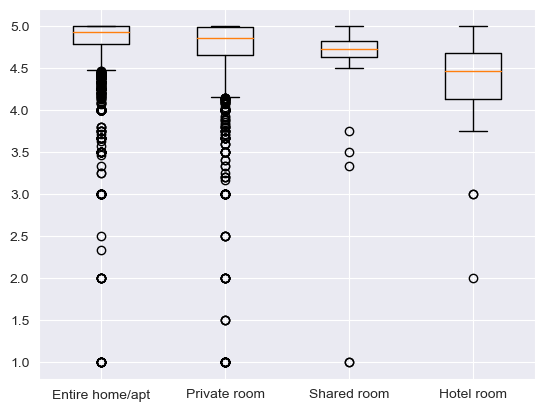

In [128]:
data = []
labels = []
for room_type in df['room_type'].unique():
    room_type_df = df.loc[df['room_type'] == room_type, 'review_scores_rating']
    data.append(room_type_df)
    labels.append(room_type)

plt.boxplot(data)
plt.xticks([1,2,3,4], labels)
plt.show()

Does 100% response rate impact the reviews?

In [129]:
hundred = df.loc[df['host_response_rate'] == 100, :] # 100% response rate has higher median reviews
print(hundred['review_scores_rating'].median())
not_hundred = df.loc[df['host_response_rate'] != 100, :]
not_hundred['review_scores_rating'].median()

4.91


4.88

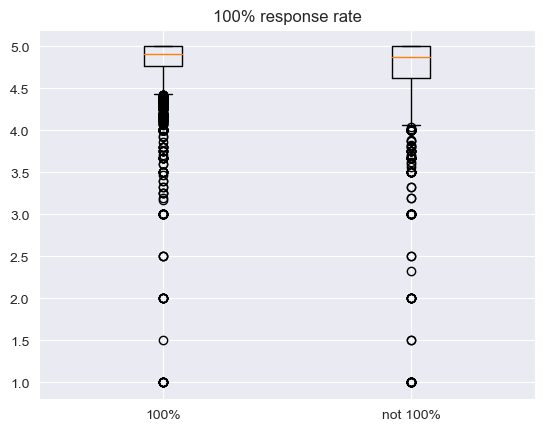

In [130]:
data = []
labels = ['100%', 'not 100%']
data.append(df.loc[df['host_response_rate'] == 100, 'review_scores_rating'])
data.append(df.loc[df['host_response_rate'] != 100, 'review_scores_rating'])

plt.boxplot(data)
plt.title('100% response rate')
plt.xticks([1,2], labels)
plt.show()

more amenities = higher mean rating?

In [131]:
bins = [0, 21, 30, 39, 49, 166]
df['amenities_group'] = pd.cut(df['num_amenities'], bins=bins)
df.groupby('amenities_group')[['review_scores_rating']].median() # more amenities = higher median rating?

,review_scores_rating
amenities_group,
"(0, 21]",4.82
"(21, 30]",4.83
"(30, 39]",4.90
"(39, 49]",4.93
"(49, 166]",4.96


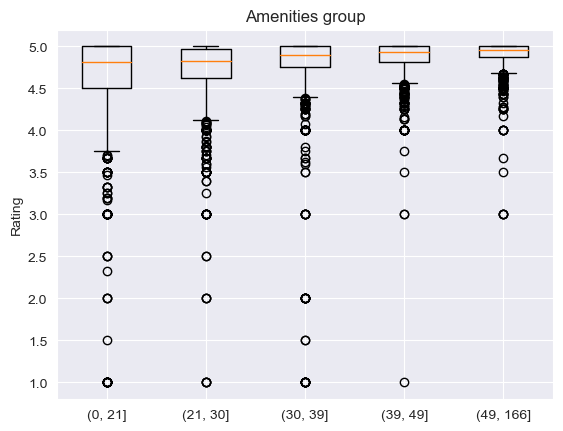

In [132]:
data = []
labs = []
for group in np.sort(df['amenities_group'].unique()):
    vals = df.loc[df['amenities_group'] == group, 'review_scores_rating']
    data.append(vals)
    labs.append(group)
# make the kde histograms so we can see the curves shifting
plt.boxplot(data)
plt.xticks([1,2, 3, 4, 5], labs)
plt.ylabel('Rating')
plt.title('Amenities group')
plt.show()

In [441]:
abs(df.corr()['review_scores_rating']).sort_values(ascending=False)

review_scores_rating                            1.000000
calculated_host_listings_count_private_rooms    0.353459
calculated_host_listings_count                  0.339906
host_is_superhost                               0.269119
num_amenities                                   0.236769
availability_30                                 0.163229
availability_60                                 0.154489
calculated_host_listings_count_entire_homes     0.146990
availability_90                                 0.143487
days_since_last_review                          0.143119
instant_bookable                                0.136988
availability_365                                0.125794
accommodates                                    0.120499
beds                                            0.108471
has_license                                     0.107604
minimum_nights_avg_ntm                          0.103369
days_as_host                                    0.103120
latitude                       

# ML SECTION

In [159]:
# First, add a categorical variable for the rating, so we can do stratified sampling
df['binned_rating'] = pd.cut(df['review_scores_rating'], bins=5, labels=[1, 2, 3, 4, 5])

Defining scaled predictors and response

In [443]:
X = pd.get_dummies(data=df, columns=['host_response_time', 'room_type', 'host_in_SF'], drop_first=True)

In [444]:
# stratify data on the outcome variable of review_scores_rating
training, testing = train_test_split(X, test_size=0.2, stratify=df['binned_rating'], random_state=35)

In [445]:
predictors_training = training[['host_response_rate', 'host_acceptance_rate', 'host_is_superhost', 'accommodates', 'beds', 'price',
                                'number_of_reviews', 'reviews_per_month', 'has_neighborhood_overview', 'days_as_host',
                                'num_host_verifications', 'days_since_first_review', 'days_since_last_review',
                                'num_amenities', 'host_response_time_a few days or more', 'host_response_time_within a day',
                                'host_response_time_within a few hours', 'host_response_time_within an hour',
                                'room_type_Hotel room', 'room_type_Private room', 'room_type_Shared room',
                                'host_in_SF_True', 'host_in_SF_Unknown', 'calculated_host_listings_count_private_rooms',
                                'calculated_host_listings_count', 'availability_30', 'availability_60',
                                'calculated_host_listings_count_entire_homes', 'availability_90', 'instant_bookable',
                                'availability_365']]

predictors_training = (predictors_training - predictors_training.mean()) / predictors_training.std()
response_training = training['review_scores_rating'].to_numpy()
response_training_binned = training['binned_rating'].to_numpy()

predictors_testing = testing[['host_response_rate', 'host_acceptance_rate', 'host_is_superhost', 'accommodates', 'beds', 'price',
                                'number_of_reviews', 'reviews_per_month', 'has_neighborhood_overview', 'days_as_host',
                                'num_host_verifications', 'days_since_first_review', 'days_since_last_review',
                                'num_amenities', 'host_response_time_a few days or more', 'host_response_time_within a day',
                                'host_response_time_within a few hours', 'host_response_time_within an hour',
                                'room_type_Hotel room', 'room_type_Private room', 'room_type_Shared room',
                                'host_in_SF_True', 'host_in_SF_Unknown', 'calculated_host_listings_count_private_rooms',
                                'calculated_host_listings_count', 'availability_30', 'availability_60',
                                'calculated_host_listings_count_entire_homes', 'availability_90', 'instant_bookable',
                                'availability_365']]
predictors_testing = (predictors_testing - predictors_testing.mean()) / predictors_testing.std()
response_testing = testing['review_scores_rating'].to_numpy()
response_testing_binned = testing['binned_rating'].to_numpy()


In [446]:
predictors_vals_training = predictors_training.to_numpy()

RandomForestRegressor()

In [464]:
num_estimators = [50, 150, 250] # TODO: plot feature importances (average the feature importances over each model)
min_samples_split = [1.0, 6, 15]
min_samples_leaf = [1, 6, 15]
max_features = [1, 'sqrt', 10]
rf_parameters = list(product(num_estimators, min_samples_split, min_samples_leaf, max_features))
rf_results = {}
feature_imps_rfr = []
for combination in rf_parameters:
    n_estimators, m_samples_split, m_samples_leaf, max_f = combination[0], combination[1], combination[2], combination[3]
    model = RandomForestRegressor(n_estimators=n_estimators, min_samples_split=m_samples_split, min_samples_leaf=m_samples_leaf,
                                  max_features=max_f)
    mse_values = []
    kfold = StratifiedKFold(n_splits=5)
    for train_idx, test_idx in kfold.split(predictors_vals_training, response_training_binned):
        x_train, x_test = predictors_vals_training[train_idx], predictors_vals_training[test_idx]
        y_train, y_test = response_training[train_idx], response_training[test_idx]
        model.fit(x_train, y_train)
        y_pred = model.predict(x_test)
        mse = mean_squared_error(y_true=y_test, y_pred=y_pred)
        mse_values.append(mse)
        fi = list(model.feature_importances_)
        feature_imps_rfr.append(fi)
    rf_results[str(combination)] = np.mean(mse_values)


In [465]:
results = pd.Series(rf_results, name='MSE').sort_values() # the 10 best models
results.head(10).sort_values()

(150, 15, 15, 10)       0.142610
(50, 15, 15, 10)        0.142735
(250, 6, 15, 10)        0.142764
(150, 15, 1, 'sqrt')    0.142839
(250, 15, 15, 10)       0.142870
(50, 6, 6, 'sqrt')      0.143127
(250, 15, 6, 'sqrt')    0.143299
(150, 6, 6, 'sqrt')     0.143389
(150, 15, 6, 'sqrt')    0.143394
(250, 15, 1, 'sqrt')    0.143412
Name: MSE, dtype: float64

In [466]:
results.std()

0.023634506782382707

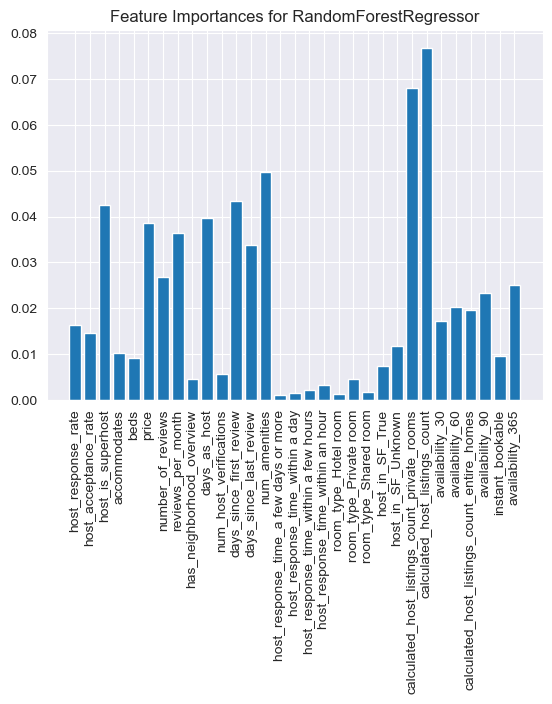

In [468]:
mean_imps = np.array(feature_imps_rfr).mean(axis=0)
imp_dict = {}
for idx, col in enumerate(predictors_training.columns):
    imp_dict[col] = mean_imps[idx]
plt.bar(x=imp_dict.keys(), height=imp_dict.values())
plt.title('Feature Importances for RandomForestRegressor')
plt.xticks(rotation=90)
plt.show()

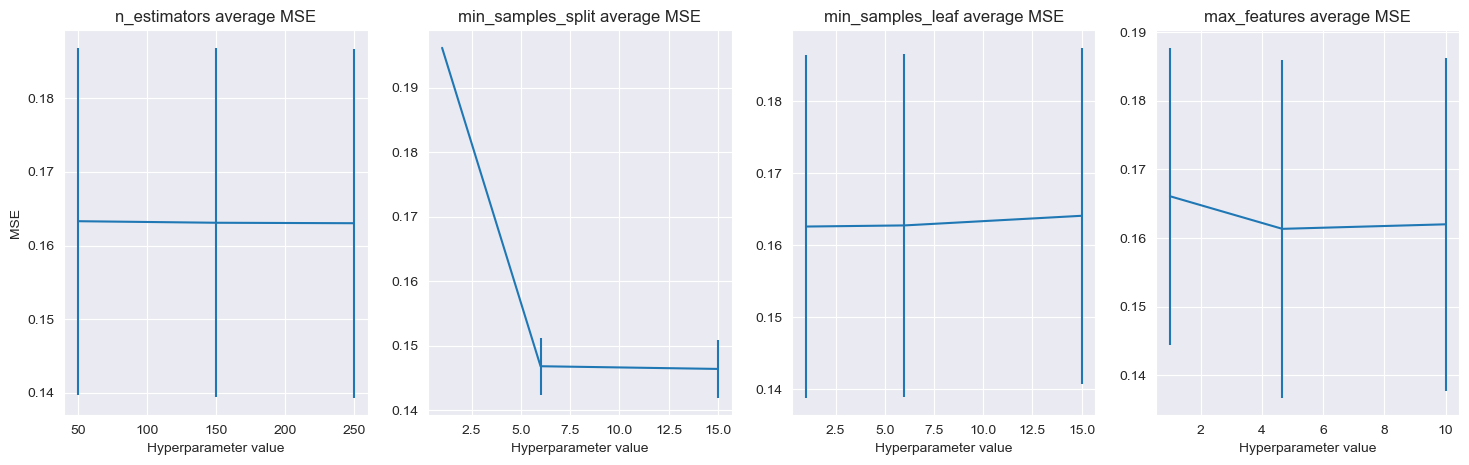

In [450]:
# the mean MSE for each parameter value
fig, axes =plt.subplots(1, 4, figsize=(18, 5))
count = 0
for param_num in range(1, 5):
    one = []
    two = []
    three = []
    for key in rf_results.keys(): # n_estimators
        if param_num == 2:
            params = min_samples_split
            param_name = 'min_samples_split'
            if 1.0 == ast.literal_eval(key)[1]:
                mse = rf_results[key]
                one.append(mse)
            if 6 == ast.literal_eval(key)[1]:
                mse = rf_results[key]
                two.append(mse)
            if 15 == ast.literal_eval(key)[1]:
                mse = rf_results[key]
                three.append(mse)
        if param_num == 1:
            params = num_estimators
            param_name = 'n_estimators'
            if 50 == ast.literal_eval(key)[0]:
                mse = rf_results[key]
                one.append(mse)
            if 150 == ast.literal_eval(key)[0]:
                mse = rf_results[key]
                two.append(mse)
            if 250 == ast.literal_eval(key)[0]:
                mse = rf_results[key]
                three.append(mse)
        if param_num == 3:
            params = min_samples_leaf
            param_name = 'min_samples_leaf'
            if 1 == ast.literal_eval(key)[2]:
                mse = rf_results[key]
                one.append(mse)
            if 6 == ast.literal_eval(key)[2]:
                mse = rf_results[key]
                two.append(mse)
            if 15 == ast.literal_eval(key)[2]:
                mse = rf_results[key]
                three.append(mse)
        if param_num == 4:
            params = [1, 4.67, 10]
            param_name = 'max_features'
            if 1 == ast.literal_eval(key)[3]:
                mse = rf_results[key]
                one.append(mse)
            if 'sqrt' == ast.literal_eval(key)[3]:
                mse = rf_results[key]
                two.append(mse)
            if 10 == ast.literal_eval(key)[3]:
                mse = rf_results[key]
                three.append(mse)
    axes[count].set_title(f'{param_name} average MSE')
    axes[count].set_xlabel('Hyperparameter value')
    axes[0].set_ylabel('MSE')
    axes[count].errorbar(x=params, y=[np.mean(one), np.mean(two), np.mean(three)], yerr=[np.std(one), np.std(two), np.std(three)])
    count += 1



LinearRegression()

In [451]:
# no parameters to tune

model = LinearRegression()
lr_results = {}
coef_list = []
for iteration in range(0, 20):
    mse_values = []
    kfold = StratifiedKFold(n_splits=5, shuffle=True) # shuffle before splitting into batches to get different results
    for train_idx, test_idx in kfold.split(predictors_vals_training, response_training_binned):
        x_train, x_test = predictors_vals_training[train_idx], predictors_vals_training[test_idx]
        y_train, y_test = response_training[train_idx], response_training[test_idx]
        model.fit(x_train, y_train)
        coefs = model.coef_
        coef_list.append(coefs)
        y_pred = model.predict(x_test)
        mse = mean_squared_error(y_true=y_test, y_pred=y_pred)
        mse_values.append(mse)
    lr_results[iteration] = mse_values

In [452]:
pd.DataFrame(lr_results).T.mean(axis=1) # average MSE across all folds for each iteration

0     0.152662
1     0.152929
2     0.154950
3     0.152803
4     0.153670
5     0.154104
6     0.152907
7     0.152804
8     0.152104
9     0.154792
10    0.152575
11    0.153978
12    0.152643
13    0.153691
14    0.153713
15    0.153486
16    0.152788
17    0.154241
18    0.153070
19    0.153131
dtype: float64

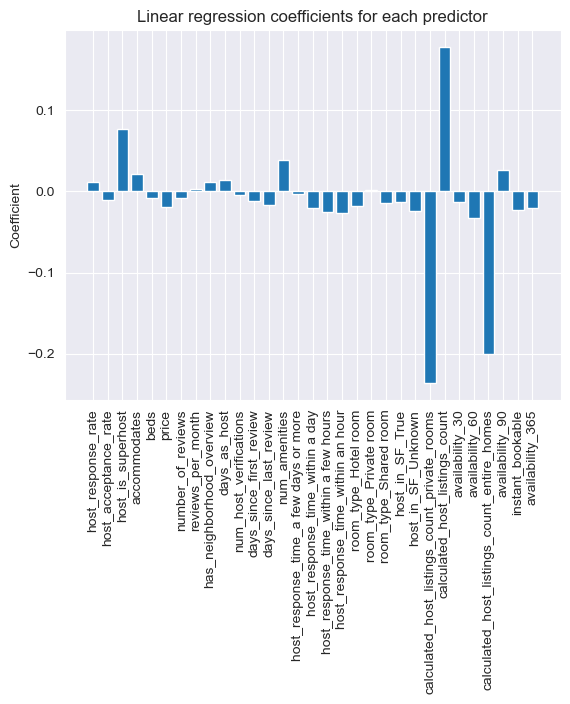

In [454]:
coef_arr = np.array(coef_list)
mean_coefs = np.mean(coef_arr, axis=0)
plt.bar(predictors_training.columns, mean_coefs)
plt.title('Linear regression coefficients for each predictor')
plt.ylabel('Coefficient')
plt.xticks(rotation=90)
plt.show()

Support Vector Regression

In [304]:
kernel = ['rbf', 'poly']
degree = [3, 4]
gamma = ['scale', 'auto']
C = [0.5, 1, 4]

svr_parameters = list(product(kernel, degree, gamma, C))
svr_results = {}
for combination in svr_parameters[:1]:
    ker, deg, gam, c = combination[0], combination[1], combination[2], combination[3]
    model = SVR(kernel=ker, degree=deg, gamma=gam, C=c)
    mse_values = []
    kfold = StratifiedKFold(n_splits=5)
    for train_idx, test_idx in kfold.split(predictors_vals_training, response_training_binned):
        x_train, x_test = predictors_vals_training[train_idx], predictors_vals_training[test_idx]
        y_train, y_test = response_training[train_idx], response_training[test_idx]
        model.fit(x_train, y_train)
        y_pred = model.predict(x_test)
        mse = mean_squared_error(y_true=y_test, y_pred=y_pred)
        mse_values.append(mse)
    svr_results[str(combination)] = np.mean(mse_values)

In [305]:
svr_results

{"('rbf', 3, 'scale', 0.5)": 0.17004604383802105}

GradientBoostingRegressor()

In [455]:
n_estimators_list = [100, 200, 300]
learning_rate_list = [0.1, 0.3, 0.6]
min_samples_split_list = [1.0, 6, 15]
min_samples_leaf_list = [1, 6, 15]

gbr_parameters = list(product(n_estimators_list, learning_rate_list, min_samples_split_list, min_samples_leaf_list))
gbr_results = {}
feature_imps = []
for combination in gbr_parameters:
    n_estimators, learning, mss, msl = combination[0], combination[1], combination[2], combination[3]
    model = GradientBoostingRegressor(n_estimators=n_estimators, learning_rate=learning, min_samples_split=mss, min_samples_leaf=msl)
    mse_values = []
    kfold = StratifiedKFold(n_splits=5)
    for train_idx, test_idx in kfold.split(predictors_vals_training, response_training_binned):
        x_train, x_test = predictors_vals_training[train_idx], predictors_vals_training[test_idx]
        y_train, y_test = response_training[train_idx], response_training[test_idx]
        model.fit(x_train, y_train)
        y_pred = model.predict(x_test)
        mse = mean_squared_error(y_true=y_test, y_pred=y_pred)
        mse_values.append(mse)
        fi = list(model.feature_importances_)
        feature_imps.append(fi)

    gbr_results[str(combination)] = np.mean(mse_values)



In [457]:
results = pd.Series(gbr_results, name='MSE').sort_values() # Top 10 GradientBoostingRegressor models
results.head(10)

(200, 0.3, 1.0, 15)    0.148307
(100, 0.3, 1.0, 6)     0.148320
(300, 0.3, 1.0, 15)    0.148324
(100, 0.3, 1.0, 15)    0.148325
(300, 0.1, 1.0, 6)     0.148391
(300, 0.1, 1.0, 15)    0.148445
(200, 0.3, 1.0, 6)     0.148500
(300, 0.3, 1.0, 6)     0.148540
(200, 0.1, 1.0, 6)     0.148797
(200, 0.1, 1.0, 15)    0.148900
Name: MSE, dtype: float64

In [458]:
results.std()

0.01744432028323493

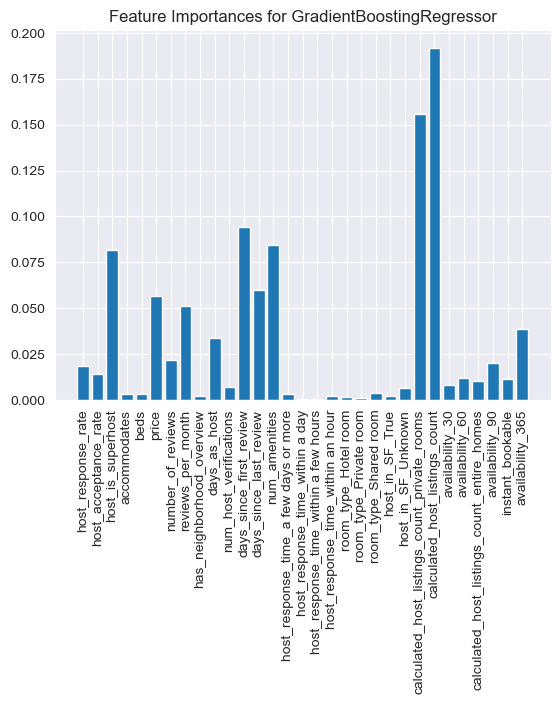

In [467]:
mean_imps = np.array(feature_imps).mean(axis=0)
imp_dict = {}
for idx, col in enumerate(predictors_training.columns):
    imp_dict[col] = mean_imps[idx]
plt.bar(x=imp_dict.keys(), height=imp_dict.values())
plt.title('Feature Importances for GradientBoostingRegressor')
plt.xticks(rotation=90)
plt.show()

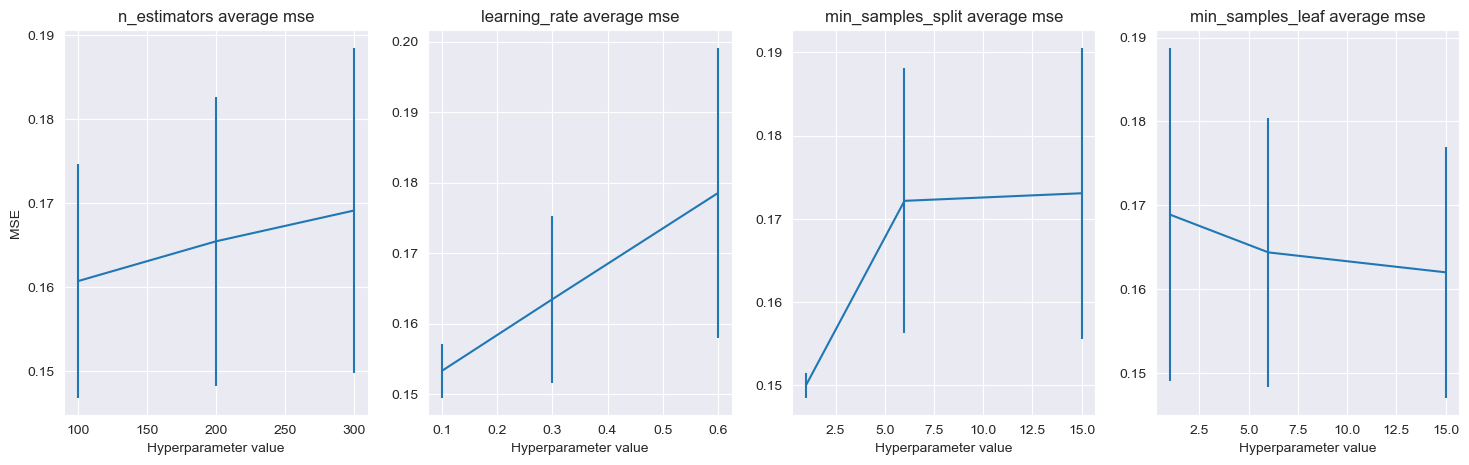

In [462]:
fig, axes = plt.subplots(1, 4, figsize=(18, 5))
param_list = [n_estimators_list, learning_rate_list, min_samples_split_list, min_samples_leaf_list]
param_name_list = ['n_estimators', 'learning_rate', 'min_samples_split', 'min_samples_leaf']
for i in range(0, 4):
    param_name = param_name_list[i]
    params = param_list[i]
    one, two, three = [], [], []
    for key in gbr_results.keys():
        key_tuple = ast.literal_eval(key)
        if key_tuple[i] == param_list[i][0]:
            mse = gbr_results[key]
            one.append(mse)
        if key_tuple[i] == param_list[i][1]:
            mse = gbr_results[key]
            two.append(mse)
        if key_tuple[i] == param_list[i][2]:
            mse = gbr_results[key]
            three.append(mse)
    axes[i].set_title(f'{param_name} average mse')
    axes[i].errorbar(x=params, y=[np.mean(one), np.mean(two), np.mean(three)], yerr=[np.std(one), np.std(two), np.std(three)])
    axes[i].set_xlabel('Hyperparameter value')
    axes[0].set_ylabel('MSE')

plt.show()

Evaluate the best model on the testing set

In [470]:
model = RandomForestRegressor(n_estimators=150, min_samples_leaf=15, min_samples_split=15, max_features=10) # (250, 6, 6, 'sqrt')
model.fit(predictors_training, response_training)
predicted_review = model.predict(predictors_testing)
test_mse = mean_squared_error(y_true=response_testing, y_pred=predicted_review)
np.sqrt(test_mse)

0.37613872987165853

In [471]:
np.std(df['review_scores_rating'])

0.44258349754907705

In [410]:
predicted_review

array([4.30433226, 4.64649888, 4.84548761, ..., 4.66820018, 4.66683626,
       4.82521311])

In [411]:
response_testing

array([4.  , 5.  , 5.  , ..., 4.58, 4.84, 4.69])

In [432]:
np.unique(response_testing_binned)

array([1, 2, 3, 4, 5])

In [430]:
predictors_testing

,host_response_rate,host_acceptance_rate,host_is_superhost,accommodates,beds,price,number_of_reviews,reviews_per_month,has_neighborhood_overview,days_as_host,...,num_amenities,host_response_time_a few days or more,host_response_time_within a day,host_response_time_within a few hours,host_response_time_within an hour,room_type_Hotel room,room_type_Private room,room_type_Shared room,host_in_SF_True,host_in_SF_Unknown
1953,-1.375470,0.165610,-1.013451,-0.622336,-0.687590,-0.155909,-0.510778,-0.643414,0.626112,0.849474,...,-0.768884,-0.121567,-0.248714,2.404377,-1.324868,-0.094761,-0.712408,-0.099015,-1.528380,2.165051
4368,0.291835,0.609347,-1.013451,-0.155678,0.099115,-0.136003,-0.519404,-0.604494,0.626112,-0.419838,...,-0.835098,-0.121567,-0.248714,-0.415571,0.754181,-0.094761,-0.712408,-0.099015,0.653758,-0.461509
95,0.291835,0.609347,0.985929,-0.622336,-0.687590,-0.111414,-0.502152,-0.653144,0.626112,1.281798,...,0.820246,-0.121567,-0.248714,-0.415571,0.754181,-0.094761,-0.712408,-0.099015,-1.528380,-0.461509
1390,-0.402876,-4.525323,-1.013451,0.310979,0.099115,-0.020083,-0.502152,-0.643414,-1.595866,0.327839,...,-0.636456,-0.121567,4.017424,-0.415571,-1.324868,-0.094761,-0.712408,-0.099015,-1.528380,-0.461509
11,-0.063327,0.609347,-1.013451,-0.622336,-0.687590,-0.140687,0.153433,-0.346648,-1.595866,0.566526,...,-2.093159,-0.121567,-0.248714,-0.415571,-1.324868,-0.094761,1.402553,-0.099015,0.653758,-0.461509
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
214,0.291835,-3.891413,-1.013451,0.777636,0.099115,-0.058723,-0.148481,-0.478003,0.626112,1.604264,...,-0.371601,-0.121567,4.017424,-0.415571,-1.324868,-0.094761,-0.712408,-0.099015,0.653758,-0.461509
7176,0.291835,0.609347,-1.013451,0.310979,0.099115,-0.087410,-0.545283,-0.190967,0.626112,0.327839,...,0.422964,-0.121567,4.017424,-0.415571,-1.324868,-0.094761,-0.712408,-0.099015,0.653758,-0.461509
3631,0.291835,0.609347,-1.013451,-0.622336,-0.687590,-0.046428,-0.450395,-0.507193,-1.595866,-1.126416,...,-0.967525,-0.121567,-0.248714,-0.415571,0.754181,-0.094761,1.402553,-0.099015,0.653758,-0.461509
1220,0.291835,-0.975428,-1.013451,-0.622336,-0.687590,-0.149469,0.576113,0.003634,0.626112,-0.051532,...,0.489178,-0.121567,-0.248714,-0.415571,0.754181,-0.094761,1.402553,-0.099015,0.653758,-0.461509


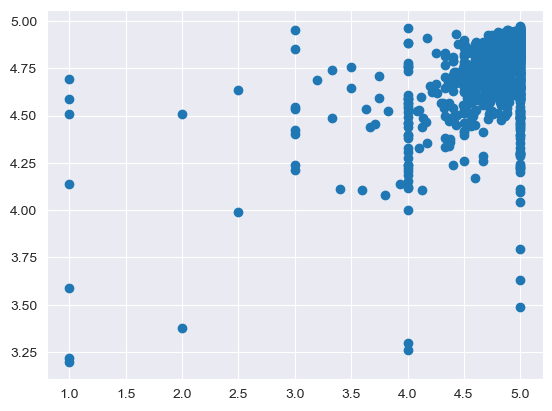

In [472]:
plt.scatter(response_testing, predicted_review)
# plt.plot(np.arange(0, 6), np.arange(0, 6), ls='--', color='grey')
# plt.yticks(ticks=np.arange(0, 6, 0.5))
plt.show()

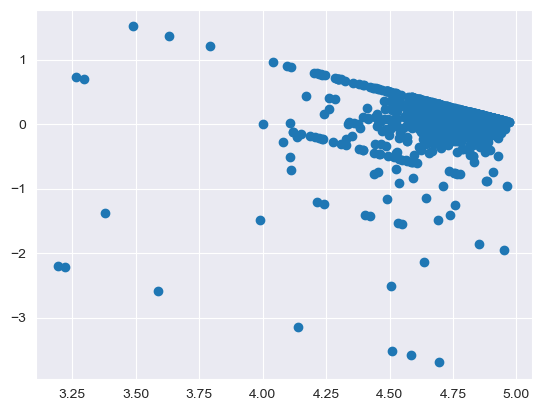

In [473]:
plt.scatter(x=predicted_review, y=response_testing - predicted_review)